# 06 - Doc2Vec
This notebook explores the governance data set using Doc2Vec. Doc2vec might be a good fit for our project as dimensionality reducer.

This code is largely based on [Document-Clustering-Doc2vec](https://github.com/aniketbote/Document-Clustering-Doc2vec/blob/master/Clustering/Clustering_code_Doc2Vec/clustering_Documents_Doc2Vec.py) by [Aniket Bote](https://github.com/aniketbote). We did remove the fixed seed for the randomizer.

Further reading [A gentle introduction to Doc2Vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) by [Gidi Shperber](https://medium.com/@gidishperber) or [Doc2Vec — Computing Similarity between Documents](https://medium.com/red-buffer/doc2vec-computing-similarity-between-the-documents-47daf6c828cd) by [Abdul Hafeez Fahad](https://medium.com/@a.h.fahad18).


** Kaartje met clusters over gemeenten, dus voor zowel LSA and Doc2Vec een kaartje genereren welke gemeenten in welk cluster zitten
XXX **

---
## Dependencies and Imports
This section deals with fulfilling depenencies and installing the right packages for use in the code below.

Something to keep in mind is that a lot of sample code out there uses Gensum version 3, where we use the current-as-of-this-writing Gensim version 4. The API has changed quite a bit between versions 3 and 4 and sample code may need to be refactored to use the new API before it works. Most changes are in the naming and will cause run-time errors, so finding problems is easy.

In [1]:
!pip install gensim fastparquet scikit-learn matplotlib wordcloud

In [2]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'
GZIP='gzip'

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import __version__ as gensim__version__
print(f"gensim=={gensim__version__}")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")

from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")
from sklearn.feature_extraction.text import TfidfVectorizer


python==3.11.4
pandas==2.0.2
gensim==4.3.1
scikit-learn==1.2.2
matplotlib==3.7.1
wordcloud==1.9.2
scikit-learn==1.2.2


---
## Load DV Data Set
This loads the DV data set. We first load as a Panda, because we have the code. Then we make the resultant `corpus` into the list of tagged documents that Gensim is designed to work with.

We also load the municipalities evaluation set. We will use that after clustering with the intention to be able to relate clusters to municipalities.

Finally, we load the document properties. These will help identify document classification issues by looking at the titles.

Spoiler alert, one of the results of outlier detection on our clustering revealed that some documents were misclassified.
The documents below are tagged as duurzaamheidvisie, but are really budget plans.

We found these as visible outliers in on of the clusters. Here we retrieve them by document title. Based on the earlier clustering run we now know what to look for.

In [3]:
DOCUMENT_ID = 'DocID'
DOCUMENT_TITLE = 'Titel'
JAAR = 'Jaar'

documents = pd.read_csv("../data/Governance/Duurzaamheidsvisies.csv", index_col=DOCUMENT_ID)
documents[JAAR] = documents[JAAR].astype(STRING).str.slice(0, 4)

documents[documents[DOCUMENT_TITLE].str.contains("egrot")]


,Titel,Jaar
DocID,,
GM0331DV01,Programmabegroting 2016,2015
GM0852DV01,Programmabegroting 2016,2016
GM0981DV01,Programma begroting 2016,2015


In [4]:
CACHE_DIR = '../cache/Governance'

# The Parquet files, gzipped.
ALL_PARQUET_GZ = CACHE_DIR + '/ALL_documents.parquet.gz'
DV_PARQUET_GZ  = CACHE_DIR + '/DV_documents.parquet.gz'

DV_corpus  = pd.read_parquet(DV_PARQUET_GZ)
ALL_corpus = pd.read_parquet(ALL_PARQUET_GZ)

# columns ofthe data set
DOCUMENT_BODY = 'body'
DOCUMENT_TITLE = 'Titel'
DOCUMENT_JAAR = 'Jaar'
MUNICIPALITY_CODE='GM_CODE'

corpus = DV_corpus
corpus.head()

,body,GM_CODE,Titel,Jaar
index,,,,
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005,Milieubeleidsplan 2009-2012,2009
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010


In [5]:
def make_into_tagged_documents(series):
    return [TaggedDocument(doc.split(' '), [i]) for i, doc in series.items()]

In [6]:
all_content = make_into_tagged_documents(corpus[DOCUMENT_BODY])
for i in range(5):
    print(f"{all_content[i].tags[0]}: {all_content[i].words[:5]}".replace("]", " ..."))

GM0003DV02: ['duurzaamheidsbeleid', 'Appingedam', 'duurzaamheidsbeleid', 'Appingedam', 'Inhoud' ...
GM0005DV01: ['colofon', 'gemeente', 'bedum', 'bezoekadres', 'Schoolstraat' ...
GM0007DV01: ['Milieubeleidsplan', 'vaststellen', 'gemeenteraad', 'bellingweden', 'maart' ...
GM0009DV01: ['inhoud', 'duurzaamheidsvisie', 'februari', 'inhoud', 'inhoud' ...
GM0034DV01: ['verseonnr', 'dagmail', 'december', 'raad', 'gemeente' ...


In [7]:
municipalities = pd.read_parquet("../data/CBS/Evaluation_data.parquet")
municipalities


,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
index,,,,,,,,,,,,,,,,,,,
0,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
1,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
2,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
3,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
4,GM0010,Delfzijl,Groningen,Klein,Arm,weinig stedelijk,Lokaal,Veel,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,GM1940,De Fryske Marren,Fryslân,Middelgroot,Modaal,weinig stedelijk,None,Gemiddeld,Veel,Veel,Gemiddeld,Gemiddeld,Gemiddeld,Middel,Laag,Middel,Middel,iets minder,meer
386,GM1942,Gooise Meren,Noord-Holland,Middelgroot,Rijk,sterk stedelijk,VVD,Geen,Beperkt,Geen,Beperkt,Geen,Beperkt,Hoog,Middel,Middel,Middel,veel lager,iets minder
387,GM1945,Berg en Dal,Gelderland,Middelgroot,Modaal,weinig stedelijk,Lokaal,Geen,Beperkt,Geen,Gemiddeld,Geen,Gemiddeld,Middel,Middel,Middel,Middel,iets minder,iets minder


---
## Train the Doc2Vec Model
With the data cleanly loaded, we can train the model. Since we are very much exploring and since training is relatively fast, we don't save the model. We simply retrain it every time.

One question that came up is whether we migth be overfitting. We have fewer than 300 documents, yet we train towards vectors of 300 dimensions. This is not a problem per se, as the training does not happen on individual documents, but rather on 5-grams of these documents. There are rather more than 300 5-grams.

Another topic we disucssed was whether 

In [8]:
d2v_model = Doc2Vec(all_content, vector_size=300, min_count=5, dm=0, alpha=0.0025, min_alpha=0.0001)
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=50, start_alpha=0.002, end_alpha=-0.016)


---
## Elbow and Cluster with K-Means
We use the learned vectors to cluster the DV data set again using K-Means clustering. First we run K-Means clustering for different cluster sizes to make the elbow plot. Then we run K-Means to find the optimal number of clusters that we chose based on the elbow plot. We chose 5.


In [9]:
nc = range(1, 100)
kmeans = [KMeans(n_clusters = i, n_init = 100, max_iter = 500) for i in nc]               
score  = [kmeans[i].fit(d2v_model.dv.vectors).inertia_ for i in range(len(kmeans))]

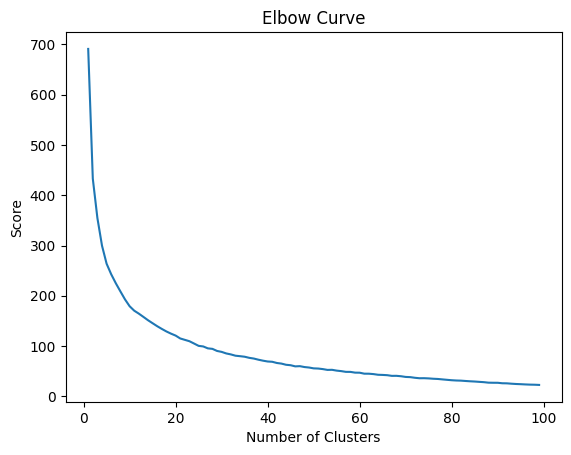

In [10]:
# Plot the elbow
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [11]:
K_value = 5
kmeans_model = KMeans(n_clusters=K_value, n_init='auto') 
kmeans_model.fit(d2v_model.dv.vectors)

__clusters = kmeans_model.predict(d2v_model.dv.vectors)
labels = kmeans_model.labels_.tolist()



## Silhouette score
The silhouette score is a metric provided by scikit-learn that measures the quality of clustering results based on the average distance between samples within clusters and the average distance between samples in different clusters. It takes into account both the cohesion (how close samples are to each other within the same cluster) and the separation (how far samples are from samples in other clusters). The range is from -1 to 1.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [12]:
silhouette_avg = silhouette_score(d2v_model.dv.vectors, labels)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.24950609


---
## PCA Analysis and Plotting
We use Principal Component Analysis (PCA) to flatten the 300-dimension document vectors onto a 2D shape for plotting. The banding in the graph below is an artefact of PCA, as the resulting components are not correlated.

In [13]:
__l = kmeans_model.predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)


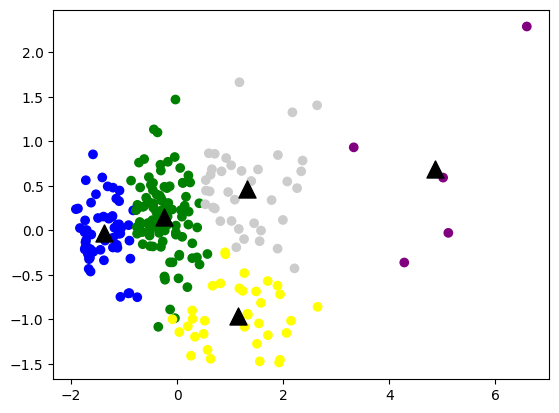

In [14]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#cccccc"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')

plt.show()


---
## Link to Municipality Data
This section three-way merges the clusters we found with the municipality data and document details for evaluation. Municipalities are indexed by their GM-code. Documents by their base file name.

In [15]:
CLUSTER='cluster'
MUNICIPALITY_ID='GM_Code'

kmeans_clusters = pd.DataFrame(index=corpus.index)
kmeans_clusters['DocID'] = corpus.index
kmeans_clusters[CLUSTER] = labels
kmeans_clusters[MUNICIPALITY_ID] = corpus.index.str.slice(0, 6)

kmeans_clusters.head()

,DocID,cluster,GM_Code
index,,,
GM0003DV02,GM0003DV02,4,GM0003
GM0005DV01,GM0005DV01,0,GM0005
GM0007DV01,GM0007DV01,0,GM0007
GM0009DV01,GM0009DV01,1,GM0009
GM0034DV01,GM0034DV01,1,GM0034


In [16]:
kmeans_clusters_with_municipalities = kmeans_clusters.merge(municipalities, how="left", on=MUNICIPALITY_ID).set_index('DocID')

# the merge adds suffixes to ensure unique column names, so we strip those off
# again since we have no name clashes.
kmeans_clusters_with_municipalities.columns=kmeans_clusters_with_municipalities.columns.str.rstrip('_x') 
kmeans_clusters_with_municipalities.head()


,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
DocID,,,,,,,,,,,,,,,,,,,,
GM0003DV02,4,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
GM0005DV01,0,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
GM0007DV01,0,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
GM0009DV01,1,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
GM0034DV01,1,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,Veel,Veel,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager


In [17]:
kmeans_clusters_with_everything = kmeans_clusters_with_municipalities.join(documents)
kmeans_clusters_with_everything.head()



,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,...,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat,Titel,Jaar
DocID,,,,,,,,,,,,,,,,,,,,,
GM0003DV02,4,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,...,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,0,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,...,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder,Milieubeleidsplan 2009-2012,2009
GM0007DV01,0,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,...,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,1,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,...,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,1,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,...,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager,Plan van aanpak duurzaamheidsagenda,2010


In [18]:
kmeans_clusters_with_everything.to_parquet("../data/Governance/Doc2Vec_clusters.parquet")
kmeans_clusters_with_everything.loc[kmeans_clusters_with_everything[CLUSTER]==4, ['GM_Code', 'Gemeente', 'Titel', 'Jaar']]


,GM_Code,Gemeente,Titel,Jaar
DocID,,,,
GM0003DV02,GM0003,Appingedam,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0037DV02,GM0037,Stadskanaal,Nota Duurzame Energie en Energiebesparing Stad...,2010
GM0079DV01,GM0079,Kollumerland en Nieuwkruisland,Duurzaamheid in Noordoost Friesland,<NA>
GM0141DV01,GM0141,Almelo,duurzaamheidsbeleidsplan 2013 - 2016,2013
GM0150DV02,GM0150,Deventer,www.deventer.nl Uitvoeringsagenda Duurzaamheid...,2011
GM0153DV01,GM0153,Enschede,Duurzaamheidsbeleid,2016
GM0166DV01,GM0166,Kampen,Energieplan 2016 - 2020 CONCEPT: Energiebesp...,2016
GM0243DV01,GM0243,Harderwijk,De Energieke Stad Een routekaart naar klimaatn...,2013
GM0268DV01,GM0268,Nijmegen,Duurzaamheid in uitvoering 2013-2017,<NA>


---
## Word Clouds and Word Lists
With the clustered established, we can now make word clouds of each of them. Before we can work with word clouds, we have to merge the K-Means clusters with the original corpus. The word clouds need the text.

In [19]:
corpus_with_cluster = corpus.join(kmeans_clusters)
corpus_with_cluster.head()


,body,GM_CODE,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,,,
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011,GM0003DV02,4,GM0003
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005,Milieubeleidsplan 2009-2012,2009,GM0005DV01,0,GM0005
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007,Milieubeleidsprogramma 2007-2015,2007,GM0007DV01,0,GM0007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016,GM0009DV01,1,GM0009
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010,GM0034DV01,1,GM0034


In [20]:
documents_with_cluster = corpus_with_cluster.iloc[:, 2:]
documents_with_cluster

,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,
GM0003DV02,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011,GM0003DV02,4,GM0003
GM0005DV01,Milieubeleidsplan 2009-2012,2009,GM0005DV01,0,GM0005
GM0007DV01,Milieubeleidsprogramma 2007-2015,2007,GM0007DV01,0,GM0007
GM0009DV01,Duurzaamheidsvisie 2016-2018,2016,GM0009DV01,1,GM0009
GM0034DV01,Plan van aanpak duurzaamheidsagenda,2010,GM0034DV01,1,GM0034
...,...,...,...,...,...
GM1945DV01,Duurzaamheidsprogramma - Gemeente Berg en Dal,2013,GM1945DV01,4,GM1945
GM1955DV01,Milieuprogramma 2014,2014,GM1955DV01,0,GM1955
GM1955DV02,Zonne-energie in het buitengebied,0,GM1955DV02,2,GM1955


In [21]:
MIN_DF=15
MAX_DF=0.95
SUBLINEAR_TF=True

def document_bodies_in_cluster(corpus, cluster):
    return corpus[corpus[CLUSTER]==cluster][DOCUMENT_BODY]

def nlargest_of(corpus, cluster, n):
    docs = document_bodies_in_cluster(corpus, cluster)

    if len(docs) < MIN_DF:
        print(f"only {len(docs)} documents in cluster {cluster}, setting `min_df` and `max_df` system defaults")
        vectorizer = TfidfVectorizer(sublinear_tf=SUBLINEAR_TF)
    else:
        vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)

    counts = vectorizer.fit_transform(docs)
    totals = counts.sum(0)
    return pd.DataFrame(totals.T, index=vectorizer.get_feature_names_out())[0].nlargest(n)

def print_cluster(corpus, cluster):
    print(nlargest_of(corpus, cluster, 20))

def cloud_of_cluster(corpus, cluster):
    cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(nlargest_of(corpus, cluster, 50))
    plt.axis('off')
    plt.imshow(cloud);


veiligheid           1.848904
extern               1.825716
afval                1.786211
stof                 1.648654
geluid               1.644027
regionaal            1.637740
water                1.626856
duurzaamheid         1.596427
milieubeleid         1.585274
bodem                1.567486
natuur               1.563898
milieubeleidsplan    1.536331
wel                  1.498805
gebouw               1.473427
weinig               1.461375
programma            1.453943
organisatie          1.446192
bouwen               1.444396
kwaliteit            1.441600
verbeteren           1.438326
Name: 0, dtype: float64


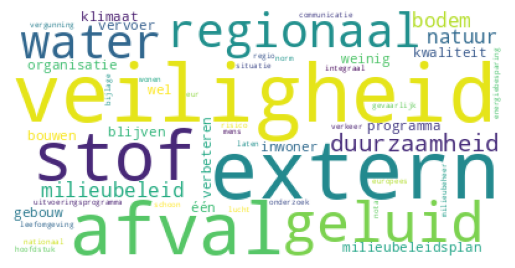

In [22]:
print_cluster(corpus_with_cluster, 0)
cloud_of_cluster(corpus_with_cluster, 0)


gebouw              3.742989
ambitie             3.620569
energiebesparing    3.553905
beleid              3.481217
inwoner             3.437862
bouwen              3.405641
doelstelling        3.383685
milieu              3.295985
opstellen           3.221626
eur                 3.180513
partij              3.177120
rol                 3.160926
thema               3.132620
ruimte              3.092488
activiteit          3.075546
natuur              3.066394
afval               3.062647
water               3.060102
maatschappelijk     3.043776
kans                3.019033
Name: 0, dtype: float64


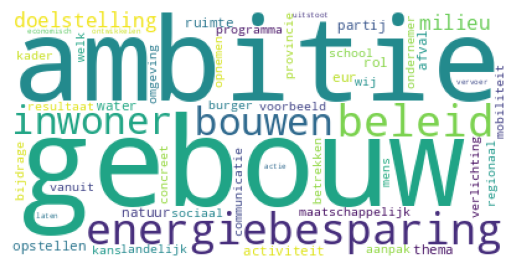

In [23]:
print_cluster(corpus_with_cluster, 1)
cloud_of_cluster(corpus_with_cluster, 1)


project             3.894674
gemeentelijk        3.582527
lokaal              3.271566
goed                3.128944
ontwikkeling        3.095024
moeten              3.038280
eur                 3.021553
energiebesparing    2.958944
inwoner             2.881328
rol                 2.813655
stimuleren          2.809072
initiatief          2.801894
thema               2.796595
gebouw              2.789137
uitvoeren           2.773275
wij                 2.757574
ambitie             2.747678
belangrijk          2.727054
ver                 2.726172
maatregel           2.678486
Name: 0, dtype: float64


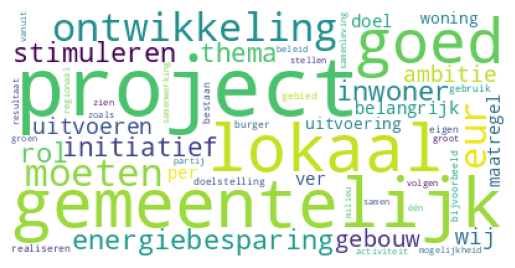

In [24]:
print_cluster(corpus_with_cluster, 2)
cloud_of_cluster(corpus_with_cluster, 2)


only 5 documents in cluster 3, setting `min_df` and `max_df` system defaults
rijswijk              0.162065
gemeente              0.159374
groen                 0.157878
gebied                0.143293
goed                  0.142942
zullen                0.142374
groot                 0.140876
landgoederenzone      0.134712
belangrijk            0.134372
bomenatuurecreatie    0.134315
per                   0.133693
moeten                0.133415
ander                 0.132722
maken                 0.132338
komen                 0.131243
liggen                0.130153
tussen                0.129490
ontwikkeling          0.129178
duurzaam              0.127802
woning                0.127280
Name: 0, dtype: float64
only 5 documents in cluster 3, setting `min_df` and `max_df` system defaults


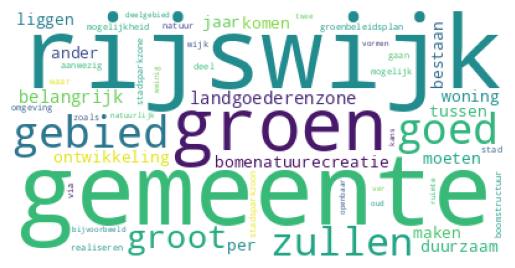

In [25]:
print_cluster(corpus_with_cluster, 3)
cloud_of_cluster(corpus_with_cluster, 3)


samen           1.748614
afval           1.630388
regionaal       1.600981
thema           1.593711
activiteit      1.545017
opstellen       1.534466
mobiliteit      1.521659
milieu          1.480116
kader           1.466922
landelijk       1.465265
sociaal         1.462587
bijlage         1.453186
verlichting     1.448789
wij             1.440051
ondernemer      1.433753
communicatie    1.411398
jaarlijks       1.406027
voorbeeld       1.402622
hierbij         1.398321
kwaliteit       1.392258
Name: 0, dtype: float64


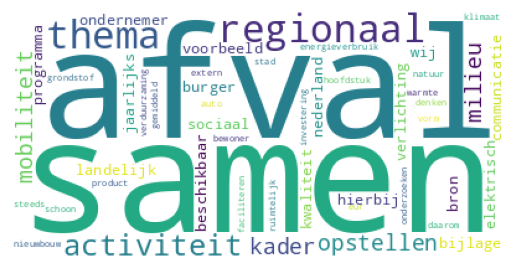

In [26]:
print_cluster(corpus_with_cluster, 4)
cloud_of_cluster(corpus_with_cluster, 4)


In [27]:
corpus_with_cluster[corpus_with_cluster[CLUSTER] == 3]

,body,GM_CODE,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,,,
GM0603DV01,Groenbeleidsplan Bomenatuurecreatie groenbelei...,GM0603,Groenbeleid deel 1,2010,GM0603DV01,3,GM0603
GM0603DV02,Groenbeleidsplan bomenatuurecreatie gemeente r...,GM0603,Groenbeleid deel 2,2010,GM0603DV02,3,GM0603
GM0928DV01,duurzaam vitaal regio regioprogramma regionaal...,GM0928,Naar een duurzame vitale regio - regioprogramm...,2015,GM0928DV01,3,GM0928
GM0986DV01,parkstad Limburg energietransitie palet palet ...,GM0986,Parkstad Limburg Energietransitie Palet),0,GM0986DV01,3,GM0986
GM1525DV03,voorstel opschrift vergadering februari Raad b...,GM1525,duurzaamheidsnota 2016,2016,GM1525DV03,3,GM1525


In [28]:
corpus_with_cluster[CLUSTER].value_counts().sort_index()

cluster
0     36
1    101
2     65
3      5
4     38
Name: count, dtype: int64

Van de vijf clusters is er een cluster met slechts 5 documenten. Dit cluster bevat duidelijk andere documenten dan duurzaamheidsvisies en milieuprogramma's. De twee documenten uit Rijswijk (GM0603) betreffen groenbeleidsplannen. Het document van Kerkrade (GM0928) is een toekomstvisie en heeft samen met de energievisie van Voerendaal (GM0986) betrekking op de Parkstad regio in Zuid-Limburg en clusteren daarom mogelijk samen.

De andere clusters zijn op basis van de belangrijkste te woorden te benoemen als (volgorde kan wisselen met de run van het notebook):
- energiebeleid
- milieubeleidsplannen
- duurzaamheidsbeleid
- afvalbeleid

---
## Redo Wordclouds, but Minus All Documents

We now redo the word clouds, but instead of looking at the word clouds for the clusters, we try to remove a layer of common words by subtracting the IDF of all documents. We did this before, as part of the "_01 - TF-IDF on the Governance Set_" notebook.

Let's first generate the TF-IDF components for all documents. This code is near-verbatim from the "_01..._" notebook.


In [29]:
def tfidf_vectorize(series, min_df, max_df, sublinear_tf):
    if len(series) < MIN_DF:
        print(f"only {len(series)} documents in cluster, setting `min_df` and `max_df` system defaults")
        vectorizer = TfidfVectorizer(sublinear_tf=SUBLINEAR_TF)
    else:
        vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)

    # run the vectorizer on the data
    word_matrix = vectorizer.fit_transform(series)
    words_list = vectorizer.get_feature_names_out()

    # take the output and package it into various useful data frames
    matrix = pd.DataFrame(index=series.index, columns=words_list, data=word_matrix.toarray())
    idf = pd.DataFrame(columns=words_list, data=[vectorizer.idf_])

    return matrix, idf


In [30]:
all_docs_matrix, _ = tfidf_vectorize(ALL_corpus[DOCUMENT_BODY], min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)

def cluster_vs_all_wordcloud(corpus_with_cluster, cluster, all_docs_matrix):
    cluster_docs_matrix, cluster_docs_idf = tfidf_vectorize(document_bodies_in_cluster(corpus_with_cluster, cluster), min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)
    
    unique_for_cluster = (cluster_docs_matrix.mean() - all_docs_matrix.mean()).dropna().sort_values()
    print(unique_for_cluster.nlargest(20))

    cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(unique_for_cluster)
    plt.axis('off')
    plt.imshow(cloud);


stof                    0.040290
geluid                  0.039739
milieubeleid            0.039335
extern                  0.038584
milieubeleidsplan       0.037986
afval                   0.037605
bodem                   0.036475
veiligheid              0.036210
gevaarlijk              0.033633
water                   0.033247
natuur                  0.031455
klimaat                 0.031140
milieubeheer            0.031109
lucht                   0.030599
vergunning              0.029273
bodemkwaliteit          0.028764
uitvoeringsprogramma    0.028723
duurzaamheid            0.028197
regionaal               0.027940
vergunningverlening     0.027302
dtype: float64


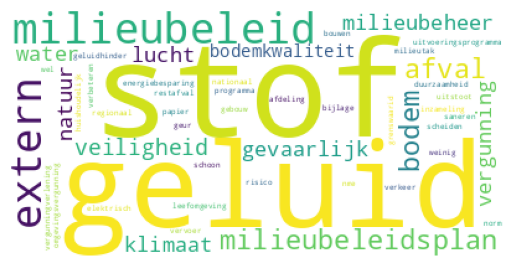

In [31]:
cluster_vs_all_wordcloud(corpus_with_cluster, 0, all_docs_matrix)


energiebesparing    0.025997
gebouw              0.023324
ambitie             0.022034
uitstoot            0.020798
mobiliteit          0.020484
elektrisch          0.020107
bouwen              0.020034
verlichting         0.019253
energieverbruik     0.019008
energieneutraal     0.018792
milieu              0.018628
voorbeeld           0.018581
natuur              0.018374
water               0.018354
afval               0.018311
thema               0.018073
doelstelling        0.017913
biomassa            0.017826
verduurzaming       0.017721
klimaatbeleid       0.017680
dtype: float64


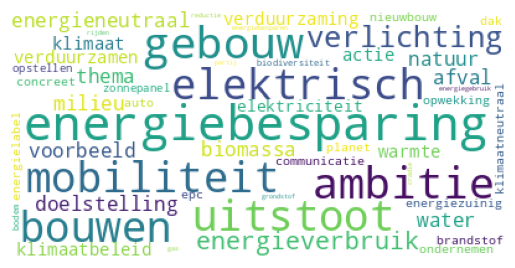

In [32]:
cluster_vs_all_wordcloud(corpus_with_cluster, 1, all_docs_matrix)


project                 0.041740
energiebesparing        0.036332
lokaal                  0.031294
thema                   0.030082
gebouw                  0.029175
ambitie                 0.028458
rol                     0.027275
initiatief              0.027054
maatregel               0.026549
actie                   0.026255
ontwikkeling            0.026187
stimuleren              0.026050
eur                     0.025627
voorbeeld               0.025213
doelstelling            0.025196
energieneutraal         0.024831
milieu                  0.024729
uitvoeringsprogramma    0.024653
elektrisch              0.024632
uitvoeren               0.024513
dtype: float64


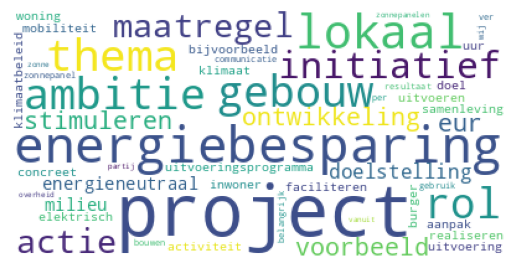

In [33]:
cluster_vs_all_wordcloud(corpus_with_cluster, 2, all_docs_matrix)


only 5 documents in cluster, setting `min_df` and `max_df` system defaults
rijswijk            0.031309
landgoederenzone    0.026437
boomstructuur       0.023028
groenbeleidsplan    0.021923
prinses             0.021531
wijkpark            0.021062
beatrixlaan         0.020877
bomenlaon           0.020131
deelgebied          0.020036
spoorlaan           0.018329
oever               0.018132
markant             0.018024
bloemrijk           0.017953
bomenrij            0.017816
droog               0.017746
vliet               0.017736
groenstructuur      0.017557
verbindingszones    0.017501
belevingswaaren     0.017286
esdoorn             0.016977
dtype: float64


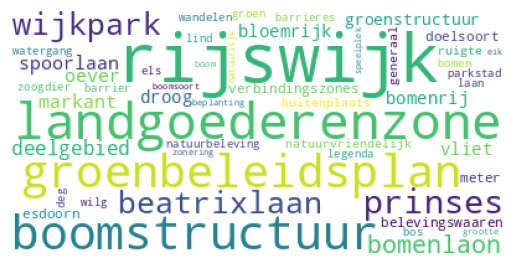

In [34]:
cluster_vs_all_wordcloud(corpus_with_cluster, 3, all_docs_matrix)


mobiliteit         0.031156
afval              0.030893
warmte             0.029969
energieverbruik    0.029356
elektrisch         0.029002
thema              0.028997
auto               0.028141
verlichting        0.028122
verduurzaming      0.027868
samen              0.027736
verduurzamen       0.027611
zonne              0.027183
bron               0.027105
grondstof          0.026820
klimaat            0.026700
brandstof          0.026414
circulair          0.026368
bijlage            0.025964
schoon             0.025843
zonnepanel         0.025836
dtype: float64


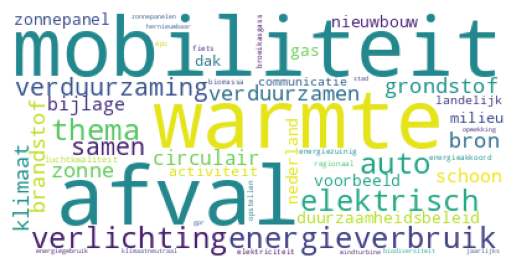

In [35]:
cluster_vs_all_wordcloud(corpus_with_cluster, 4, all_docs_matrix)
